# Preliminary Data Analysis for the Jin - Hafix Disinformation Index

Our first attempt at this analysis produced a correlation matrix and heatmap which depicted the strengths of associations between mask-wearing rates, non-medical exemption (NME) rates for vaccinations, and climate change disbelief rates (please see the "Data Sources" document for details on these datasets). However, there were no observable associations.

The current task is to create multipliers for factors that affect the disinformation index. We will use feature selection to approach this problem, and focus on one outcome at a time. Opinions on climate change and NME rates might be more nuanced than we think, affected by microcultural factors. Let's just take a look at mask-wearing rates to begin with.

The variables we are looking at to find possible predictors: *Race, gender, poverty status, education, unemployment, Internet access.*  
The variable we are seeking to understand as an outcome of these predictors: *Mask-wearing.*

In [66]:
# Import packages.
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy import stats
%matplotlib inline

# This probably isn't best practice.
import warnings
warnings.filterwarnings("ignore")

In [67]:
# Get census data.
census = pd.read_csv("~/Downloads/cc-est2019-alldata.csv",encoding = "ISO-8859-1")

In [68]:
# Reduce census data to only include 2019.
census = census[(census['YEAR'] ==12)]

# Reduce census data to include all ages; we can divide it by age group in further analysis.
census = census[(census['AGEGRP'] == 0)]

In [69]:
# Adjust census data column values to match FIPS values for other datasets.
census['COUNTY'] = census['STATE']*1000+census['COUNTY']

# Rename column to 'FIPS' to match other datasets.
census = census.rename(columns={'COUNTY': 'FIPS'})

# However, the the first (alphabetically) FIPS codes are four digits; they should be five. 
# The other FIPS codes match; we only need to fix these.

# Convert to string data type.
census['FIPS'] = census['FIPS'].astype(str)

# Where the code is less than five digits, add a zero in front. 
census['FIPS'] = census['FIPS'].str.zfill(5)

We want to examine race and gender as possible predictors of mask-wearing. We're just going to check for association between male and mask-wearing, instead of both male and female. The census survey methodology does not seem to account for more than two genders. Therefore, male + female proportions will approximate a whole. So, we only need to look at one.

Additionally, we will only be checking for association between White-alone racial identity and mask-wearing, instead of checking all races. Other published analyses have found that rates of not wearing masks consistently are highest among white populations; for simplicity's sake, we will begin with one racial identity group first. 

In [70]:
# Creating column for male gender as a proportion of the total population. 
census["MALE_PROP"] = (census["TOT_MALE"] / census["TOT_POP"]).astype(float)

# Creating column for White racial identity as a proportion of the total population.
census["WA_PROP"] = ((census["WA_MALE"] + census["WA_FEMALE"])/census["TOT_POP"]).astype(float)

In [71]:
census.head(5)

,SUMLEV,STATE,FIPS,STNAME,CTYNAME,YEAR,AGEGRP,TOT_POP,TOT_MALE,TOT_FEMALE,...,HBAC_MALE,HBAC_FEMALE,HIAC_MALE,HIAC_FEMALE,HAAC_MALE,HAAC_FEMALE,HNAC_MALE,HNAC_FEMALE,MALE_PROP,WA_PROP
209,50,1,01001,Alabama,Autauga County,12,0,55869,27092,28777,...,89,93,40,27,15,19,16,11,0.484920,0.762623
437,50,1,01003,Alabama,Baldwin County,12,0,223234,108247,114987,...,268,281,264,197,69,65,55,35,0.484904,0.874410
665,50,1,01005,Alabama,Barbour County,12,0,24686,13064,11622,...,63,50,61,26,1,0,14,8,0.529207,0.491534
893,50,1,01007,Alabama,Bibb County,12,0,22394,11929,10465,...,32,19,6,15,5,1,17,3,0.532687,0.767661
1121,50,1,01009,Alabama,Blount County,12,0,57826,28472,29354,...,76,58,67,66,18,21,34,21,0.492374,0.958254


Next, we will bring in datasets for the four other factors we want to examine: poverty status, education, unemployment, and Internet access. Similar to the race and gender proportion columns, we will create columns of each status we are interested in as a proportion of total population. 

In [72]:
# Get poverty status data. 
poverty = pd.read_csv("~/Downloads/ACSDT5Y2019.B17005_data_with_overlays_2021-01-20T235335.csv",encoding = "ISO-8859-1")

# Remove the first row, which has another set of column names.
poverty = poverty.iloc[1:]

# Creating column for population below poverty level in the last year as proportion of total population in this survey.
poverty["B17005_002E"] = poverty["B17005_002E"].astype(float)
poverty["B17005_001E"] = poverty["B17005_001E"].astype(float)
poverty["POV_PROP"] = poverty["B17005_002E"] / poverty["B17005_001E"]

# We need to create a column for the FIPS code, so we can merge our newly created POV_PROP column with other data.
# The GEO_ID column has a lengthy code, the last five digits of which is our FIPS code. 
# We'll be doing this for the other datasets as well. 

# Slicing the last 5 digits from the GEO_ID.
poverty["FIPS"]= poverty["GEO_ID"].str.slice(-5) 

In [73]:
# Get educational attainment data. 
education = pd.read_csv("~/Downloads/ACSST5Y2019.S1501_data_with_overlays_2021-01-14T191030.csv",
                        encoding = "ISO-8859-1")

# Remove the first row, which has another set of column names.
education = education.iloc[1:]

# Creating column for proportion of people 25 years and over that do not have any college degree. 
education["S1501_C01_006E"] = education["S1501_C01_006E"].astype(float)
education["S1501_C01_007E"] = education["S1501_C01_007E"].astype(float)
education["S1501_C01_008E"] = education["S1501_C01_008E"].astype(float)
education["S1501_C01_009E"] = education["S1501_C01_009E"].astype(float)
education["S1501_C01_010E"] = education["S1501_C01_010E"].astype(float)

education["ED_PROP"] = (education["S1501_C01_007E"] + education["S1501_C01_008E"] + education["S1501_C01_009E"] 
                        + education["S1501_C01_010E"]) / education["S1501_C01_006E"]

# Slicing the last 5 digits from the GEO_ID.
education["FIPS"]= education["GEO_ID"].str.slice(-5)

In [74]:
# Get unemployment data. 
unemployment = pd.read_csv("~/Downloads/ACSST5Y2019.S2301_data_with_overlays_2021-01-16T111928.csv",
                           encoding = "ISO-8859-1")

# Remove the first row, which has another set of column names.
unemployment = unemployment.iloc[1:]

# This dataset already has the figure we are looking for; unemployment rate for people 20-64 years old. 
# The column is "S2301_C04_021E". This seems to be a percentage; let's convert it to a proportion for consistency.
unemployment["S2301_C04_021E"] = unemployment["S2301_C04_021E"].astype(float)
unemployment["UNEMP_PROP"] = (unemployment["S2301_C04_021E"] / 100)

# So, all we need is to create a column for the FIPS code.
# Slicing the last 5 digits from the GEO_ID.
unemployment["FIPS"]= unemployment["GEO_ID"].str.slice(-5)

In [75]:
# Get Internet access data.
internet = pd.read_csv("~/Downloads/ACSDT1Y2019.B28002_data_with_overlays_2021-01-19T103125.csv",
                           encoding = "ISO-8859-1")

# Remove the first row, which has another set of column names.
internet = internet.iloc[1:]

# Creating column for proportion of people that either have Internet access without a subsciption, or no access. 
internet["B28002_012E"] = internet["B28002_012E"].astype(float)
internet["B28002_013E"] = internet["B28002_013E"].astype(float)
internet["B28002_001E"] = internet["B28002_001E"].astype(float)

internet["INT_PROP"] = (internet["B28002_012E"] + internet["B28002_013E"]) / internet["B28002_001E"]

# Slicing the last 5 digits from the GEO_ID.
internet["FIPS"]= internet["GEO_ID"].str.slice(-5)

Next, we'll take a look at the data for the outcome we are currently interested in understanding: mask use by county. 

There are five survey responses that are columns in this dataset: "always", "frequently", "sometimes", "rarely", and "never." It is possible that due to the perception that a "never" response would be ill-received or judged in a certain light, respondents that actually relate to the "never" category may have responded "rarely" or "sometimes".  It might be helpful to combine the "never" and "rarely" categories, to obtain one category that can be understood to represent "low mask usage".

In [76]:
# Get mask use data.
mask = pd.read_csv("~/Downloads/mask-use-by-county.csv", encoding = "ISO-8859-1")

# Creating column to combine "never" and "rarely" survey responses.
mask["NEVER"] = mask["NEVER"].astype(float)
mask["RARELY"] = mask["RARELY"].astype(float)
mask["LOW_USE"] = mask["NEVER"] + mask["RARELY"]

# We need to create a column for the FIPS code. 
# There is a column that seems to contain this code, but like the census data, some are missing the first digit. 
# The first few FIPS codes are four digits; they should be five.

# Convert to string data type.
mask["COUNTYFP"] = mask["COUNTYFP"].astype(str)

# Where the code is less than five digits, add a zero in front. 
mask["FIPS"] = mask["COUNTYFP"].str.zfill(5)

In [77]:
# Time to merge the columns we've created in each dataset with the census data.
# From the "poverty" dataframe: poverty["POV_PROP"]
# From the "education" dataframe: education["ED_PROP"]
# From the "unemployment" dataframe: unemployment["UNEMP_PROP"]
# From the "internet" dataframe: internet["INT_PROP"]
# From the "mask" dataframe: mask["LOW_USE"]
# Merging on FIPS

census_joined = pd.merge(census, poverty[['FIPS','POV_PROP']],on='FIPS', how='left')
census_joined = pd.merge(census_joined, education[['FIPS','ED_PROP']],on='FIPS', how='left')
census_joined = pd.merge(census_joined, unemployment[['FIPS','UNEMP_PROP']],on='FIPS', how='left')
census_joined = pd.merge(census_joined, internet[['FIPS','INT_PROP']],on='FIPS', how='left')
census_joined = pd.merge(census_joined, mask[['FIPS','LOW_USE']],on='FIPS', how='left')

In [78]:
census_joined.head(5)

,SUMLEV,STATE,FIPS,STNAME,CTYNAME,YEAR,AGEGRP,TOT_POP,TOT_MALE,TOT_FEMALE,...,HAAC_FEMALE,HNAC_MALE,HNAC_FEMALE,MALE_PROP,WA_PROP,POV_PROP,ED_PROP,UNEMP_PROP,INT_PROP,LOW_USE
0,50,1,01001,Alabama,Autauga County,12,0,55869,27092,28777,...,19,16,11,0.484920,0.762623,0.132707,0.650226,0.035,NaN,0.127
1,50,1,01003,Alabama,Baldwin County,12,0,223234,108247,114987,...,65,55,35,0.484904,0.874410,0.095816,0.586902,0.040,0.131029,0.142
2,50,1,01005,Alabama,Barbour County,12,0,24686,13064,11622,...,0,14,8,0.529207,0.491534,0.250535,0.812180,0.094,NaN,0.188
3,50,1,01007,Alabama,Bibb County,12,0,22394,11929,10465,...,1,17,3,0.532687,0.767661,0.157835,0.822674,0.070,NaN,0.054
4,50,1,01009,Alabama,Blount County,12,0,57826,28472,29354,...,21,34,21,0.492374,0.958254,0.121823,0.743761,0.031,NaN,0.167


In [79]:
# INT_PROP is looking sparse. 
# Checking to see how many NaN values there are, as a proportion of total rows.  
census_joined["INT_PROP"].isna().sum() / len(census_joined.index)

0.7361553150859326

In [80]:
# Looks like our Internet data was missing a lot of counties. 
# We'll have to omit Internet access as a factor for now; we can revisit this later. 

# Just checking the location (index) of the columns we'll be referring to. 
columns = census_joined.columns

# X variables:
race_loc = columns.get_loc("WA_PROP")
gender_loc = columns.get_loc("MALE_PROP")
pov_loc = columns.get_loc("POV_PROP")
ed_loc = columns.get_loc("ED_PROP")
unemp_loc = columns.get_loc("UNEMP_PROP")

# Y variable: 
mask_loc = columns.get_loc("LOW_USE")

print("X variables are located at:" + str(gender_loc) + "," + str(race_loc) + "," + str(pov_loc) 
      + "," + str(ed_loc) + "," + str(unemp_loc))
print("Y variable is located at:" + str(mask_loc))

X variables are located at:80,81,82,83,84
Y variable is located at:86


Now that our data is formatted properly, we can use feature selection. We have numerical inputs and a numerical output; so, the best move is to approach this as a regression predictive modeling problem. We will compute Pearon's correlation coefficient to understand our data. We could also calculate Spearman's rank coefficient, but Pearson is more likely to be useful to us. Spearman is generally more appropriate for data involving ranks, i.e. ordinal data.

Before we calculate the scores we need, let's take a look at some plots. 

,MALE_PROP,WA_PROP,POV_PROP,ED_PROP,UNEMP_PROP,LOW_USE
MALE_PROP,1.000000,0.091801,-0.028744,0.196083,-0.030586,0.073148
WA_PROP,0.091801,1.000000,-0.443696,-0.064983,-0.499384,0.221081
POV_PROP,-0.028744,-0.443696,1.000000,0.469082,0.620972,0.026019
ED_PROP,0.196083,-0.064983,0.469082,1.000000,0.364094,0.235640
UNEMP_PROP,-0.030586,-0.499384,0.620972,0.364094,1.000000,-0.152238
LOW_USE,0.073148,0.221081,0.026019,0.235640,-0.152238,1.000000


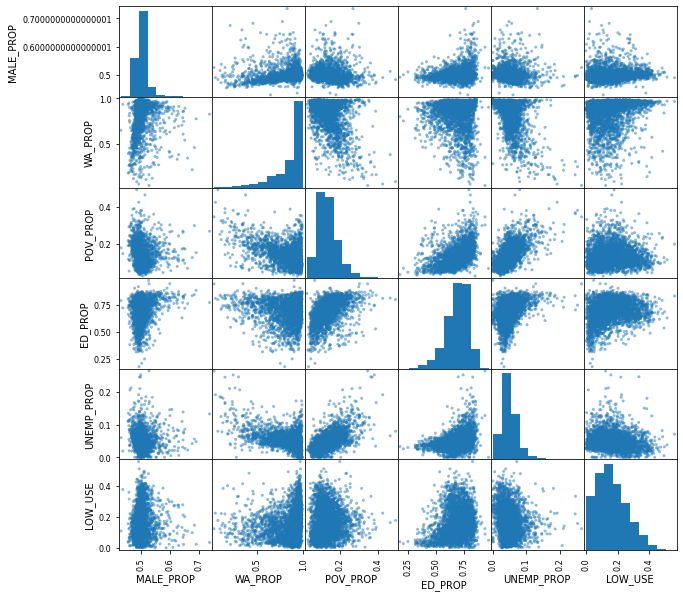

In [81]:
# Defining our x/independent and y/dependent variables.
x = census_joined.iloc[:,80:85]
y = census_joined.iloc[:,-1:]

# Making a scatterplot.
plt.rcParams['figure.figsize'] = [10, 10]
scatter = pd.concat([x,y], axis = 1)
pd.plotting.scatter_matrix(scatter)

# Table of correlations
scatter.corr()

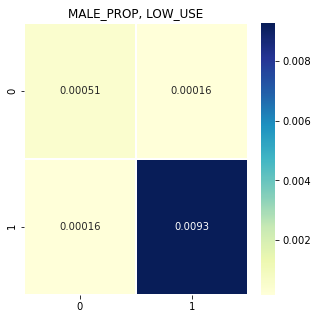

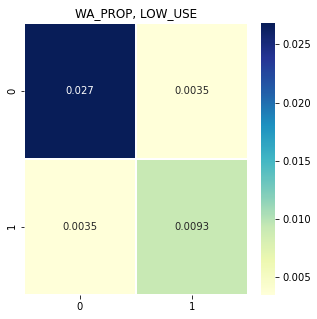

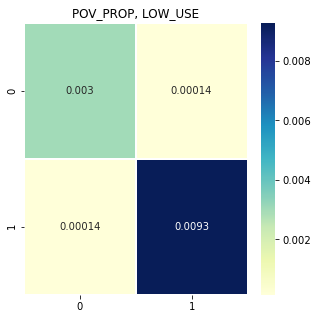

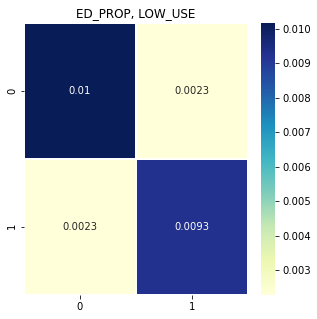

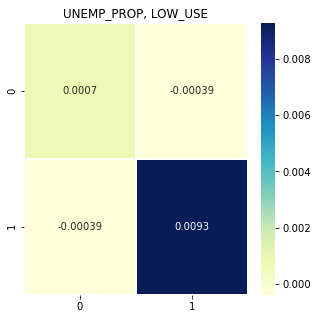

In [82]:
# Making separate coviariance tables.

# MALE_PROP, LOW_USE
plt.rcParams['figure.figsize'] = [5, 5]
male_cov = np.asarray(census_joined["MALE_PROP"])
mask_cov = np.asarray(census_joined["LOW_USE"])
ax = plt.axes()
sns.heatmap(np.cov(male_cov, mask_cov,bias=True), ax = ax, annot = True, linewidths=.5, cmap="YlGnBu")
ax.set_title('MALE_PROP, LOW_USE')
plt.show()

# WA_PROP, LOW_USE
wa_cov = np.asarray(census_joined["WA_PROP"])
ax = plt.axes()
sns.heatmap(np.cov(wa_cov, mask_cov,bias=True), ax = ax, annot = True, linewidths=.5, cmap="YlGnBu")
ax.set_title('WA_PROP, LOW_USE')
plt.show()

# POV_PROP, LOW_USE
pov_cov = np.asarray(census_joined["POV_PROP"])
ax = plt.axes()
sns.heatmap(np.cov(pov_cov, mask_cov,bias=True), ax = ax, annot = True, linewidths=.5, cmap="YlGnBu")
ax.set_title('POV_PROP, LOW_USE')
plt.show()

# ED_PROP, LOW_USE
ed_cov = np.asarray(census_joined["ED_PROP"])
ax = plt.axes()
sns.heatmap(np.cov(ed_cov, mask_cov,bias=True), ax = ax, annot = True, linewidths=.5, cmap="YlGnBu")
ax.set_title('ED_PROP, LOW_USE')
plt.show()

# UNEMP_PROP, LOW_USE
unemp_cov = np.asarray(census_joined["UNEMP_PROP"])
ax = plt.axes()
sns.heatmap(np.cov(unemp_cov, mask_cov,bias=True), ax = ax, annot = True, linewidths=.5, cmap="YlGnBu")
ax.set_title('UNEMP_PROP, LOW_USE')
plt.show()

In [83]:
# Pearsons
from scipy.stats import pearsonr
pearson_df = census_joined[["MALE_PROP", "WA_PROP", "POV_PROP", "ED_PROP", "UNEMP_PROP", "LOW_USE"]]

pearson_df.corr(method='pearson', min_periods=1)

,MALE_PROP,WA_PROP,POV_PROP,ED_PROP,UNEMP_PROP,LOW_USE
MALE_PROP,1.000000,0.091801,-0.028744,0.196083,-0.030586,0.073148
WA_PROP,0.091801,1.000000,-0.443696,-0.064983,-0.499384,0.221081
POV_PROP,-0.028744,-0.443696,1.000000,0.469082,0.620972,0.026019
ED_PROP,0.196083,-0.064983,0.469082,1.000000,0.364094,0.235640
UNEMP_PROP,-0.030586,-0.499384,0.620972,0.364094,1.000000,-0.152238
LOW_USE,0.073148,0.221081,0.026019,0.235640,-0.152238,1.000000


#### Interpreting analysis and next steps
The analysis above does not indicate very strong statistical associations. However, there are a number of possible explanations for this. As noted in previous sections (please read all comments), the data was filtered based on rationale aimed at simplifying the dataset. We could rethink this rationale, and reconsider the fields we decided to examine. The census datasets in particular are very granular, and allow for a lot of detail. Next steps could include including different columns, along with different datasets alltogether. The above analysis should still be repeated for two other dependent variables: climate change opinions, and NME rates. 

In the Pearsons table of results (above), there do appear to be stronger associations between racial identity and low usage, as well as educational attainment and low usage. This could be further explored.

#### Conclusion
Ultimately, we should bear in mind that the goal of this analysis is not necessarily to find predictors of mask-wearing, but to use these outcomes--mask-wearing, climate change disbelief, and NME rates--as proxies for disinformation. Keeping in mind that we will want to supplement this data with more dynamic data sourced from social media, this is not a bad starting point for assigning multipliers for factors that are already supported by our literature review. 